# Deep learning model and correction of bias

Hypothesis: removing variables ZIP, rent, job_stability and occupation reduces bias against minority in model. 

Removing variables rent, ZIP, occupation and job_stability removes bias from model according to demographic parity, equal opportunity and equalised odds measurements.

In [1]:
import numpy as np
import pandas as pd

In [27]:
#import pre_processed train dataset
train = pd.read_csv('train_preprocessed.csv', index_col=0)
print('train shape: ' + str(train.shape))
train.head()

train shape: (471136, 13)


,minority,sex,ZIP,rent,education,age,income,loan_size,payment_timing,year,job_stability,occupation,default
0,1,0,1,1,57.230650,36.050927,205168.022244,7600.292199,3.302193,0,3.015554,1,1
1,1,0,1,1,45.891343,59.525251,187530.409981,5534.271289,3.843058,0,5.938132,1,1
2,1,0,1,1,46.775489,67.338108,196912.006690,2009.903438,2.059034,0,2.190777,1,1
3,1,0,1,1,41.784839,24.067401,132911.650615,3112.280893,3.936169,0,1.725860,1,1
4,1,0,1,1,41.744838,47.496605,161162.551205,1372.077093,3.709910,0,0.883104,1,1


In [28]:
#import pre_processed test dataset
test = pd.read_csv('test_preprocessed.csv', index_col=0)
print('test shape: ' + str(test.shape))
test.head()

test shape: (160000, 13)


,minority,sex,ZIP,rent,education,age,income,loan_size,payment_timing,job_stability,year,occupation,default
0,1,0,1,1,51.265723,25.710781,166455.209729,8064.951996,3.874735,43.764963,30,1,1
1,0,0,1,0,58.882849,39.689510,216752.885725,7166.701945,3.809001,46.903977,30,0,0
2,0,0,1,0,56.504545,25.847324,183764.480788,3322.045258,3.497214,63.453467,30,0,0
3,1,0,1,1,47.074111,26.381109,154057.004978,15.223904,3.535370,56.243840,30,1,0
4,1,0,1,1,48.916960,18.779902,143463.038107,7860.534547,3.663330,49.884194,30,1,0


In [20]:
#train dataset
X_tr_nob = train.drop(['default', 'minority', 'rent', 'job_stability', 'occupation', 'sex', 'ZIP'], axis=1)
X_tr_bias = train.drop(['default', 'minority', 'sex'], axis=1)
y_train= train['default']

#test dataset
X_te_nob = test.drop(['default', 'minority', 'rent', 'job_stability', 'occupation', 'sex', 'ZIP'], axis=1)
X_te_bias = test.drop(['default', 'minority', 'sex'], axis=1)
y_test = test['default']

In [21]:
from sklearn.preprocessing import StandardScaler

#Scale X train/test bias
scaler = StandardScaler()
X_fit_bias = scaler.fit(X_tr_bias)

X_train_bias = X_fit_bias.transform(X_tr_bias)
X_test_bias = X_fit_bias.transform(X_te_bias)

#Scale X train/test no bias
scaler = StandardScaler()
X_fit_nob = scaler.fit(X_tr_nob)

X_train_nob = X_fit_nob.transform(X_tr_nob)
X_test_nob = X_fit_nob.transform(X_te_nob)

# Linear classificaiton: Base Model

In [29]:
#linear classification
from  sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#bias
lr_bias = LogisticRegression(solver='lbfgs')
lr_bias.fit(X_train_bias, y_train)

y_pred_bias = lr_bias.predict(X_test_bias)
accuracy_lr_bias = accuracy_score(y_pred_bias, y_test)


#no bias
lr_nob = LogisticRegression(solver='lbfgs')
lr_nob.fit(X_train_nob, y_train)

y_pred_nob = lr_nob.predict(X_test_nob)
accuracy_lr_nob = accuracy_score(y_pred_nob, y_test)

#print accuracy
print('Accuracy with bias: ' + str(round(accuracy_lr_bias*100,2)) + '%')
print('Accuracy with no bias: ' + str(round(accuracy_lr_nob*100,2)) + '%')

Accuracy with bias: 35.15%
Accuracy with no bias: 50.03%


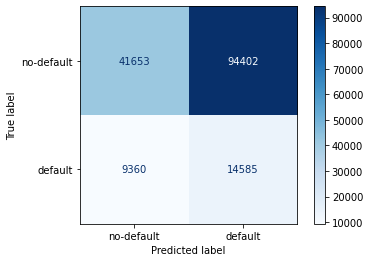

In [31]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(lr_bias, 
                      X_test_bias, 
                      y_test,
                      display_labels=['no-default', 'default'],
                      cmap=plt.cm.Blues)
plt.grid(False)

# Deep Learning

In [51]:
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

In [38]:
#stop if no improvement in loss after 3 epochs
es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [343]:
def create_model(df):
    ## Initialize model.
    model = Sequential() #if you want a recurrent NN, then specify here Recurrent()

    ## 1st Layer
    model.add(Dense(64, input_dim=df.shape[1]))
    model.add(Activation('relu'))
    model.add(Dropout(0.5)) #25% of neurons are de-activated randomly per batch. helps with generalisation.

    ## 2nd Layer
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.5)) #dropout number is arbitrary. trail and error. 

    ## Adding Softmax Layer
    model.add(Dense(1))
    model.add(Activation('sigmoid')) #softmax used for classification. softmax = [0,1]

    ## Define loss function
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

## Model with bias dataset

In [344]:
#bias
FNN_bias = create_model(X_train_bias)
FNN_bias.fit(X_train_bias, y_train, epochs=100, batch_size=1000, shuffle=True, verbose=2, callbacks=[es_callback])

Epoch 1/100
 - 2s - loss: 0.0743 - accuracy: 0.9726
Epoch 2/100
 - 2s - loss: 0.0036 - accuracy: 0.9996
Epoch 3/100
 - 2s - loss: 0.0028 - accuracy: 0.9997
Epoch 4/100
 - 2s - loss: 0.0026 - accuracy: 0.9998
Epoch 5/100
 - 2s - loss: 0.0024 - accuracy: 0.9998
Epoch 6/100
 - 2s - loss: 0.0022 - accuracy: 0.9998
Epoch 7/100
 - 2s - loss: 0.0021 - accuracy: 0.9998
Epoch 8/100
 - 2s - loss: 0.0020 - accuracy: 0.9998
Epoch 9/100
 - 2s - loss: 0.0020 - accuracy: 0.9998
Epoch 10/100
 - 2s - loss: 0.0020 - accuracy: 0.9998
Epoch 11/100
 - 2s - loss: 0.0019 - accuracy: 0.9998
Epoch 12/100
 - 2s - loss: 0.0018 - accuracy: 0.9998
Epoch 13/100
 - 2s - loss: 0.0018 - accuracy: 0.9998
Epoch 14/100
 - 1s - loss: 0.0018 - accuracy: 0.9998
Epoch 15/100
 - 1s - loss: 0.0017 - accuracy: 0.9998
Epoch 16/100
 - 1s - loss: 0.0018 - accuracy: 0.9998
Epoch 17/100
 - 2s - loss: 0.0016 - accuracy: 0.9998
Epoch 18/100
 - 2s - loss: 0.0016 - accuracy: 0.9998
Epoch 19/100
 - 2s - loss: 0.0016 - accuracy: 0.9998
Ep

In [345]:
#bias
loss_dl_bias, accuracy_dl_bias = FNN_bias.evaluate(X_test_bias, y_test)
print('Test loss with bias: ' + str(round(loss_dl_bias, 2)))
print('Test accuracy with bias: ' + str(round(accuracy_dl_bias*100, 2)))

160000/160000 [==============================] - 3s 18us/step
Test loss with bias: 8.22
Test accuracy with bias: 57.08


In [346]:
#bias
y_pred_bias = FNN_bias.predict_classes(X_test_bias)

#bias confusion_matrix
confusion_matrix(y_test, y_pred_bias)

#scikit learn has a different convention for confusion matrix. 
# [tn, fp]
# [fn, tp]

array([[82283, 53772],
       [14900,  9045]])

## Model with non-bias dataset

In [42]:
#no bias
FNN_nob = create_model(X_train_nob)
FNN_nob.fit(X_train_n1ob, y_train, epochs=100, batch_size=1000, shuffle=True, verbose=2, callbacks=[es_callback])

Epoch 1/100
 - 2s - loss: 0.4535 - accuracy: 0.7108
Epoch 2/100
 - 1s - loss: 0.0661 - accuracy: 0.9883
Epoch 3/100
 - 2s - loss: 0.0329 - accuracy: 0.9933
Epoch 4/100
 - 2s - loss: 0.0256 - accuracy: 0.9943
Epoch 5/100
 - 2s - loss: 0.0231 - accuracy: 0.9946
Epoch 6/100
 - 1s - loss: 0.0203 - accuracy: 0.9950
Epoch 7/100
 - 2s - loss: 0.0190 - accuracy: 0.9951
Epoch 8/100
 - 1s - loss: 0.0186 - accuracy: 0.9950
Epoch 9/100
 - 1s - loss: 0.0175 - accuracy: 0.9952
Epoch 10/100
 - 2s - loss: 0.0172 - accuracy: 0.9952
Epoch 11/100
 - 2s - loss: 0.0170 - accuracy: 0.9953
Epoch 12/100
 - 2s - loss: 0.0161 - accuracy: 0.9953
Epoch 13/100
 - 2s - loss: 0.0159 - accuracy: 0.9953
Epoch 14/100
 - 2s - loss: 0.0155 - accuracy: 0.9955
Epoch 15/100
 - 2s - loss: 0.0157 - accuracy: 0.9954
Epoch 16/100
 - 2s - loss: 0.0155 - accuracy: 0.9954
Epoch 17/100
 - 1s - loss: 0.0154 - accuracy: 0.9955
Epoch 18/100
 - 1s - loss: 0.0156 - accuracy: 0.9954
Epoch 19/100
 - 2s - loss: 0.0153 - accuracy: 0.9954
Ep

In [49]:
#no bias
loss_dl_nob, accuracy_dl_nob = FNN_nob.evaluate(X_test_nob, y_test)
print('Test loss with no bias: ' + str(round(loss_dl_nob, 2)))
print('Test accuracy with no bias: ' + str(round(accuracy_dl_nob*100, 2)))

160000/160000 [==============================] - 3s 18us/step
Test loss with no bias: 7.57
Test accuracy with no bias: 64.96


In [56]:
#no bias
y_pred_nob = FNN_nob.predict_classes(X_test_nob)

#bias confusion_matrix
confusion_matrix(y_test, y_pred_nob)

#scikit learn has a different convention for confusion matrix. 
# [tn, fp]
# [fn, tp]

array([[79999, 56056],
       [    1, 23944]])

# Fairness of model

In [138]:
def bias_analysis(X_test_df, y_test_df, df_column_names, model, bias, minority):
    """ 
    X_test_df = X_test after StandardScaler transformation
    y_test_df = y_test 
    df_columns_names = X_test dataframe before StandardScaler transformation
    model = deep learning model
    bias = 0 or 1
    minority = 0 or 1
    """
    
    #join minority variable to X and y dataframes to differentiate between minority and non-minority
    X_test_min = np.concatenate((X_test_df, 
                                 test['minority'].values.reshape(-1,1)), 
                                axis=1)
    y_test_min = np.concatenate((y_test_df.values.reshape(-1,1),
                                 test['minority'].values.reshape(-1,1)), 
                                axis=1)
    
    #column headings for dataframe that will be converted from array
    columns = np.insert(df_column_names.columns, X_test_df.shape[1], 'minority')
    
    #convert numpy array to dataframe
    df_X_test = pd.DataFrame(X_test_min, columns=columns)
    df_y_test = pd.DataFrame(y_test_min, columns=['default','minority'])
    
    #subset minority==1, minority group
    X_minority = df_X_test[df_X_test['minority']==minority].values
    y_minority = df_y_test[df_y_test['minority']==minority].values
    
    #predict y
    y_pred_minority = model.predict_classes(X_minority[:,:X_test_df.shape[1]])

    #evaluate accuracy
    loss_dl_min, accuracy_dl_min = model.evaluate(X_minority[:,:X_test_df.shape[1]], y_minority[:,0])
    
    confusion = confusion_matrix(y_minority[:,0], y_pred_minority)
    
    if bias == 1:
        if minority == 1:
        
            print('Test loss bias minority: ' + str(round(loss_dl_min, 2)))
            print('Test accuracy bias minority: ' + str(round(accuracy_dl_min*100, 2)) + '%')

            print()

            return confusion

        else:

            print('Test loss bias non-minority: ' + str(round(loss_dl_min, 2)))
            print('Test accuracy bias non-minority: ' + str(round(accuracy_dl_min*100, 2)) + '%')

            print()

            return confusion
      
    #bias=0
    if bias == 0:
        if minority == 1:

            print('Test loss non-bias minority: ' + str(round(loss_dl_min, 2)))
            print('Test accuracy non-bias minority: ' + str(round(accuracy_dl_min*100, 2)) + '%')

            print()

            return confusion

        else:
            
            print('Test loss non-bias non-minority: ' + str(round(loss_dl_min, 2)))
            print('Test accuracy non-bias non-minority: ' + str(round(accuracy_dl_min*100, 2)) + '%')

            print()

            return confusion

In [139]:
def bias_check(bias, minority):
    """
    bias = 0 or 1
        bias==1 means dataset is biased
    minority = 0 or 1
        minority==1 means minority is analysed

    """
    
    if bias == 1:
        result = bias_analysis(X_test_bias, y_test, X_te_bias, FNN_bias, bias=bias, minority=minority)
        return result
    
    if bias == 0:
        result = bias_analysis(X_test_nob, y_test, X_te_nob, FNN_nob, bias=bias, minority=minority)
        return result

In [179]:
confusion_bias_minority = bias_check(bias=1, minority=1)

80348/80348 [==============================] - 1s 17us/step
Test loss bias minority: 7.52
Test accuracy bias minority: 26.55%



In [194]:
confusion_bias_non_minority = bias_check(bias=1, minority=0)

79652/79652 [==============================] - 2s 21us/step
Test loss bias non-minority: 2.22
Test accuracy bias non-minority: 84.65%



In [149]:
confusion_non_bias_minority = bias_check(bias=0, minority=1)

80348/80348 [==============================] - 1s 17us/step
Test loss non-bias minority: 7.61
Test accuracy non-bias minority: 64.76%



In [150]:
confusion_non_bias_non_minority = bias_check(bias=0, minority=0)

79652/79652 [==============================] - 1s 18us/step
Test loss non-bias non-minority: 7.52
Test accuracy non-bias non-minority: 65.17%



<img src=confusionMatrix.jpg>

<img src=metrics_1.png>

# Demographic Parity

Really good article explaining fairness measures in ML
https://towardsdatascience.com/how-to-define-fairness-to-detect-and-prevent-discriminatory-outcomes-in-machine-learning-ef23fd408ef2

Positive rate for both minority and non-minority should be the same. This means that the rate of (false positive + true positive) be similar for both groups. For example, the model should predict a 50% default rate in both minority and non-minority. 

Overall, demographic parity does not exist for this dataset since 99% default rate is predicted for the minority group and less than 1% for the non-minority group.

<img src=demographic_parity.png>

In [185]:
def demographic_parity(result, bias=0, minority=0):
    """
    bias = 0 or 1
        bias==1 means dataset is biased
    minority = 0 or 1
        minority==1 means minority is analysed

    """
    
    tn, fp, fn, tp = result.ravel()
    #tn, fp, fn, tp = bias_check(bias, minority).ravel()
    
    temp = (fp + tp) / (tn + fp + fn + tp)
    demo_parity = round(temp*100, 2) 
    
    if bias == 1:
        if minority == 0:
            print('Demographic parity for bias non-minority: ' + str(demo_parity) + '%')
            return demo_parity
        
        else: 
            print('Demographic parity for bias minority: ' + str(demo_parity) + '%')
            return demo_parity    
    if bias == 0:
        if minority == 0:
            print('Demographic parity for non-bias non-minority: ' + str(demo_parity) + '%')
            return demo_parity        
        else: 
            print('Demographic parity for non-bias minority: ' + str(demo_parity) + '%')
            return demo_parity            

In [340]:
def if_equal(df):
    for index, row in df.iterrows():
        if abs(row['minority'] - row['non-minority'])> 2:
            df.loc[index, 'equal'] = 'No'
        else:
            df.loc[index, 'equal'] = 'Yes'
        

In [337]:
demo_parity = pd.DataFrame(index=['bias', 'non-bias'])

In [338]:
#bias
demo_parity.loc['bias', 'minority'] = demographic_parity(confusion_bias_minority, bias=1, minority=1)
demo_parity.loc['bias', 'non-minority'] = demographic_parity(confusion_bias_non_minority, bias=1, minority=0)

Demographic parity for bias minority: 85.62%
Demographic parity for bias non-minority: 1.04%


In [339]:
#non-bias
demo_parity.loc['non-bias', 'minority'] = demographic_parity(confusion_non_bias_minority, bias=0, minority=1)
demo_parity.loc['non-bias', 'non-minority'] = demographic_parity(confusion_non_bias_non_minority, bias=0, minority=0)

Demographic parity for non-bias minority: 50.27%
Demographic parity for non-bias non-minority: 49.73%


In [347]:
if_equal(demo_parity)
demo_parity

,minority,non-minority,equal
bias,85.62,1.04,No
non-bias,50.27,49.73,Yes


# Equal Opportunity

The false negative and true positive rate should be the same for both groups. 

Overall, equal opportunity exists since both groups correctly predict default rate to 100%. 

<img src=equal_opportunity.png>

In [252]:
def equal_opportunity(result, bias=0, minority=0):
    """
    bias = 0 or 1
        bias==1 means dataset is biased
    minority = 0 or 1
        minority==1 means minority is analysed

    """
    
    tn, fp, fn, tp = result.ravel()
    #tn, fp, fn, tp = bias_check(bias, minority).ravel()
    
    temp = tp / (fn + tp)
    equal_opportunity = round(temp*100, 2) 
    
    if bias == 1:
        if minority == 0:
            print('Equal opportunity for bias non-minority: ' + str(equal_opportunity) + '%')
            return equal_opportunity
        
        else: 
            print('Equal opportunity for bias minority: ' + str(equal_opportunity) + '%')
            return equal_opportunity
    
    if bias == 0:
        if minority == 0:
            print('Equal opportunity for non-bias non-minority: ' + str(equal_opportunity) + '%')
            return equal_opportunity
        
        else: 
            print('Equal opportunity for non-bias minority: ' + str(equal_opportunity) + '%')
            return equal_opportunity

In [268]:
equal_opp = pd.DataFrame(index=['bias', 'non-bias'])

In [269]:
#bias
equal_opp.loc['bias', 'minority'] = equal_opportunity(confusion_bias_minority, bias=1, minority=1)
equal_opp.loc['bias', 'non-minority'] = equal_opportunity(confusion_bias_non_minority, bias=1, minority=0)

Equal opportunity for bias minority: 90.49%
Equal opportunity for bias non-minority: 1.98%


In [270]:
#non-bias
equal_opp.loc['non-bias', 'minority'] = equal_opportunity(confusion_non_bias_minority, bias=0, minority=1)
equal_opp.loc['non-bias', 'non-minority'] = equal_opportunity(confusion_non_bias_non_minority, bias=0, minority=0)

Equal opportunity for non-bias minority: 100.0%
Equal opportunity for non-bias non-minority: 99.99%


In [348]:
if_equal(equal_opp)
equal_opp

,minority,non-minority,equal
bias,90.49,1.98,No
non-bias,100.00,99.99,Yes


# Equalised Odds

<img src=equalised_odds.png>

In [253]:
def equalised_odds(result, bias=0, minority=0):
    """
    bias = 0 or 1
        bias==1 means dataset is biased
    minority = 0 or 1
        minority==1 means minority is analysed

    """
    
    tn, fp, fn, tp = result.ravel()
    #tn, fp, fn, tp = bias_check(bias, minority).ravel()
    
    temp = tp / (fn + tp)
    equalised_odds = round(temp*100, 2) 
    
    if bias == 1:
        if minority == 0:
            print('Equalised odds for bias non-minority: ' + str(equalised_odds) + '%')
            return equalised_odds
        
        else: 
            print('Equalised odds for bias minority: ' + str(equalised_odds) + '%')
            return equalised_odds
    
    if bias == 0:
        if minority == 0:
            print('Equalised odds for non-bias non-minority: ' + str(equalised_odds) + '%')
            return equalised_odds
        
        else: 
            print('Equalised odds for non-bias minority: ' + str(equalised_odds) + '%')
            return equalised_odds

In [290]:
equal_odds = pd.DataFrame(index=['bias', 'non-bias'])

In [291]:
#bias
equal_odds.loc['bias', 'minority'] = equalised_odds(confusion_bias_minority, bias=1, minority=1)
equal_odds.loc['bias', 'non-minority'] = equalised_odds(confusion_bias_non_minority, bias=1, minority=0)

Equalised odds for bias minority: 90.49%
Equalised odds for bias non-minority: 1.98%


In [292]:
#non-bias
equal_odds.loc['non-bias', 'minority'] = equalised_odds(confusion_non_bias_minority, bias=0, minority=1)
equal_odds.loc['non-bias', 'non-minority'] = equalised_odds(confusion_non_bias_non_minority, bias=0, minority=0)

Equalised odds for non-bias minority: 100.0%
Equalised odds for non-bias non-minority: 99.99%


In [349]:
if_equal(equal_odds)
equal_odds

,minority,non-minority,equal
bias,90.49,1.98,No
non-bias,100.00,99.99,Yes
